## comparison with non-parametric models

click [here](https://www.notion.so/oliveiracaio/in-progress-computing-the-average-neural-activity-across-trials-for-gbyk-17ca2d01e2ff80a3af78f5c06c8b0fbc?pvs=4) to access the corresponding notion page.

In [274]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

PLOTS_FOLDER = os.path.join("plots", "nonparametric_models")

In [2]:
from pathlib import Path

os.chdir(Path().resolve().parent)

### load data

In [3]:
sessions = ["bex_20230623", "ken_20230614", "ken_20230618"]
trial_start = {session: [] for session in sessions}
trial_end = {session: [] for session in sessions}
choice = {session: [] for session in sessions}
choice2idx = {session: dict() for session in sessions}
com_dict = {session: [] for session in sessions}
responses_dict = {session: [] for session in sessions}

for session in sessions:
    TRIALS_DIR = os.path.join(session, "trials")
    for trial in sorted(f for f in os.listdir(TRIALS_DIR)):
        with open(os.path.join(TRIALS_DIR, trial), "rb") as f:
            meta = yaml.safe_load(f)
        choice[session].append(meta["choice"])
        start = meta["first_frame_idx"]
        end = start + meta["num_frames"]
        duration = end - start
        remainder = duration % 50
        idxs_adjustment = remainder != 0
        adjustment = np.where(idxs_adjustment, remainder, 0)
        start_adjustment = adjustment // 2
        end_adjustment = adjustment - start_adjustment
        trial_start[session].append(int(start + start_adjustment))
        trial_end[session].append(int(end - end_adjustment))

    POSES_DIR = os.path.join(session, "poses")
    with open(os.path.join(POSES_DIR, "meta", "com.npy"), "rb") as f:
        com = np.load(f)
        com_dict[session] = [
            com[b // 10 : e // 10, :].reshape((e - b) // 50, 5, 3).mean(axis=1)
            for b, e in zip(trial_start[session], trial_end[session])
        ]

    choice2idx[session] = {
        "L": np.where(np.array(choice[session]) == "L")[0],
        "R": np.where(np.array(choice[session]) == "R")[0],
    }

    RESP_DIR = os.path.join(session, "responses")
    with open(os.path.join(RESP_DIR, "meta.yaml"), "r") as f:
        resp_meta = yaml.safe_load(f)

    responses = np.memmap(
        os.path.join(RESP_DIR, "data.mem"),
        dtype=resp_meta["dtype"],
        mode="r",
        shape=(resp_meta["n_timestamps"], resp_meta["n_signals"]),
    )

    responses_dict[session] = [
        responses[b:e].reshape((e - b) // 50, 50, -1).sum(axis=1)
        for b, e in zip(trial_start[session], trial_end[session])
    ]

### plot functions

In [4]:
sns.set_context("poster", font_scale=2)
sns.set_style("white")
sns.set_theme(style="ticks")

In [ ]:
def plot_global_corr(dataframe, filename):
    g = sns.catplot(
        data=dataframe,
        x="area",
        y="correlation",
        hue="area",
        col="session",
        kind="box",
        palette="Purples",
        legend=False,
        linewidth=1.2,
        flierprops={"marker": "o", "markersize": 8, "markeredgewidth": 1.2},
    )

    g.fig.set_size_inches(8, 4)
    sns.despine(trim=True)
    axs = list(g.axes.flat)
    axs[0].set_title("Monkey B")
    axs[1].set_title("Monkey K, Session 1")
    axs[2].set_title("Monkey K, Session 2")
    g.set_ylabels("Correlation", labelpad=5)
    g.set_xlabels("")

    plt.tight_layout()
    plt.savefig(
        f"{PLOTS_FOLDER}/{filename}.svg",
        format="svg",
        bbox_inches="tight",
    )
    plt.show()

In [ ]:
def plot_local_corr(dataframe, filename):
    g = sns.catplot(
        data=dataframe,
        x="area",
        y="local_correlation",
        hue="area",
        col="session",
        kind="box",
        palette="Oranges",
        legend=False,
        linewidth=1.2,
        flierprops={"marker": "o", "markersize": 8, "markeredgewidth": 1.2},
    )

    g.fig.set_size_inches(8, 4)
    sns.despine(trim=True)
    axs = list(g.axes.flat)
    axs[0].set_title("Monkey B")
    axs[1].set_title("Monkey K, Session 1")
    axs[2].set_title("Monkey K, Session 2")
    g.set_ylabels("Local Correlation", labelpad=5)
    g.set_xlabels("")

    plt.tight_layout()
    plt.savefig(
        f"{PLOTS_FOLDER}/{filename}.svg",
        format="svg",
        bbox_inches="tight",
    )
    plt.show()

### leave-one-out correlation

- find the max length among the trials that have at least 10 other trials with the same length
- crop all the trials to have such max length
- leave one trial out at a time and average the other trials
- concatenate all the trials and the averaged trials into two big time series
- correlate the time series
- additionally, i'm doing all the above separating per condition. if the left out trial was a precue trial in which the monkey chose left, all the trials involved in the previous items are precue trials in which the monkey chose left.

In [7]:
def loo_pred(trials, conditions, min_overlap=10):
    preds = {condition: None for condition in conditions}
    gt = {condition: None for condition in conditions}

    for cond, idxs in conditions.items():
        ts = [trials[idx] for idx in idxs]
        max_len = max(
            [
                len(t)
                for t in ts
                if sum(1 for x in ts if len(x) >= len(t)) >= min_overlap
            ]
        )

        trials_matrix = np.full((len(ts), max_len), np.nan)
        for i, t in enumerate(ts):
            trials_matrix[i, : len(t)] = t[:max_len]

        loo_sum = np.nansum(trials_matrix, axis=0) - trials_matrix
        loo_count = np.sum(~np.isnan(trials_matrix), axis=0) - 1
        loo_means = loo_sum / loo_count

        trials_matrix = trials_matrix.ravel()
        trials_matrix = trials_matrix[~np.isnan(trials_matrix)]
        loo_means = loo_means.ravel()
        loo_means = loo_means[~np.isnan(loo_means)]

        preds[cond] = loo_means
        gt[cond] = trials_matrix

    return preds, gt

### local leave-one-out correlation

- find the max length among the trials that have at least 10 other trials with the same length
- crop all the trials to have such max length
- leave one trial out at a time and average the other trials
- crop the trials once again such that they become divisible by 1s
- reshape the trials and the averaged trials into 1s intervals
- correlate the intervals
- compute the average correlation per trial
- compute the average correlation across trials
- additionally, i'm doing all the above separating per condition. if the left out trial was a precue trial in which the monkey chose left, all the trials involved in the previous items are precue trials in which the monkey chose left.

In [8]:
def local_looc(trials, conditions, min_overlap=10, sec=20):
    corr = {condition: [] for condition in conditions}

    for cond, idxs in conditions.items():
        ts = [trials[idx] for idx in idxs]
        max_len = max(
            [
                len(t)
                for t in ts
                if sum(1 for x in ts if len(x) >= len(t)) >= min_overlap
            ]
        )

        trials_matrix = np.full((len(ts), max_len), np.nan)
        for i, t in enumerate(ts):
            trials_matrix[i, : len(t)] = t[:max_len]

        loo_sum = np.nansum(trials_matrix, axis=0) - trials_matrix
        loo_count = np.sum(~np.isnan(trials_matrix), axis=0) - 1
        loo_means = loo_sum / loo_count

        # to make it divisible by 1 second.
        crop = trials_matrix.shape[-1] - (trials_matrix.shape[-1] % sec)
        trials_matrix = trials_matrix[..., :crop]
        trials_matrix = np.reshape(trials_matrix, (len(ts), -1, sec))
        loo_means = loo_means[..., :crop]
        loo_means = np.reshape(loo_means, (len(ts), -1, sec))

        trial_corr = np.empty((len(ts),))
        for t in range(len(ts)):
            intervals_corr = []
            for i in range(len(trials_matrix[t])):
                y = trials_matrix[t, i]
                y = y[~np.isnan(y)]
                y_hat = loo_means[t, i]
                y_hat = y_hat[~np.isnan(y_hat)]
                if len(y) > 2:
                    intervals_corr.append(np.corrcoef(y, y_hat)[0, 1])
            trial_corr[t] = np.nanmean(intervals_corr)

        corr[cond].append(np.mean(trial_corr))

    return np.mean(np.concatenate(list(corr.values())))

### spatial leave-one-out correlation

the math behind this alignment is as follows:
let $\{\mathbf{r}_\tau(t) : \tau=1,\ldots,n\}$ be the set with the ground truth neural activity over all trials and $\{y_\tau(t) : \tau=1,\ldots,n\}$ be the set with the $y$-axis of the center of mass of all trials.
notice that i’m assuming $\mathbf{r}_\tau$ and $y_\tau$ represent the same trial.
then, first of all, for each trial $\tau$ i compute the average of the neural activity per tile $\mathfrak{tl}$:
$$
\widetilde{\mathbf{r}}_\tau(\mathfrak{tl}) = \sum_{t \in Y_{\mathfrak{tl}}} \frac{\mathbf{r}_\tau(t)}{|Y_{\mathfrak{tl}}|},
$$
being $Y_{\mathfrak{tl}} = \{t : y_\tau(t) \in \mathfrak{tl}\}$ and $\mathfrak{tl} \in \{1, \ldots, 5\}$ one of the 5 tiles in the $y$-axis.
secondly, i average the result across trials (leaving the $\tau$-th trial out):
$$
\overline{\mathbf{r}}_\tau(\mathfrak{tl}) = \sum_{\tau' \neq \tau} \frac{\widetilde{\mathbf{r}}_{\tau'}(\mathfrak{tl})}{n-1}.
$$
to conclude, the predicted neural activity for the $\tau$-th trial is:
$$
\widehat{\mathbf{r}}_\tau(t) = \overline{\mathbf{r}}_\tau(\mathfrak{tl}),
$$
being $\mathfrak{tl}$ such that $y_\tau(t) \in \mathfrak{tl}$.

In [ ]:
def spatial_looc(
    trials_responses, trials_com, conditions, tile_swap, n_tiles=5
):
    tiles_edges = np.linspace(0, 1, n_tiles + 1)
    preds = {condition: [] for condition in conditions}
    gt = {condition: [] for condition in conditions}

    # Precompute all digitized tile indices
    com_digitized = {
        i: np.digitize(trials_com[i], tiles_edges) - 1
        for i in range(len(trials_com))
    }

    for c, idxs in conditions.items():
        responses = [trials_responses[i] for i in idxs]
        coms = [com_digitized[i] for i in idxs]
        for i_idx, i in enumerate(idxs):
            # Exclude trial i
            other_coms = coms[:i_idx] + coms[i_idx + 1 :]
            other_responses = responses[:i_idx] + responses[i_idx + 1 :]

            # Concatenate data from all other trials
            concat_coms = np.concatenate(other_coms)
            concat_responses = np.concatenate(other_responses)

            # Accumulate spike counts and counts per tile
            spike_sum = np.bincount(
                concat_coms, weights=concat_responses, minlength=n_tiles
            )
            time_spent_tile = np.bincount(concat_coms, minlength=n_tiles)

            loo_avg_spike_per_tile = spike_sum / time_spent_tile

            # Predict using the tile assignment of the held-out trial
            trial_coms = coms[i_idx].copy()
            for src, dst in tile_swap.items():
                trial_coms[coms[i_idx] == src] = dst
            prediction = loo_avg_spike_per_tile[trial_coms]

            preds[c].append(prediction)
            gt[c].append(responses[i_idx])

        preds[c] = np.concatenate(preds[c])
        gt[c] = np.concatenate(gt[c])

    return preds, gt

### align the start of the trial

In [10]:
start_dict = {
    "area": [],
    "session": [],
    "correlation": [],
    "local_correlation": [],
}

for session in sessions:
    with open(
        os.path.join(session, "responses", "meta", "areas.npy"), "rb"
    ) as f:
        areas = np.load(f)
        start_dict["area"].extend(areas)
        start_dict["session"].extend([session] * len(areas))

    for ch in range(len(areas)):
        trials = [trial[:, ch] for trial in responses_dict[session]]

        pred, gt = loo_pred(trials, choice2idx[session])
        concat_pred = np.concatenate(list(pred.values()))
        concat_gt = np.concatenate(list(gt.values()))
        corr = np.corrcoef(concat_pred, concat_gt)[0, 1]
        start_dict["correlation"].append(corr)

        local_corr = local_looc(trials, choice2idx[session])
        start_dict["local_correlation"].append(local_corr)

/Users/caio/datasets/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/caio/datasets/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/b2/8s0j82vd4439gm59q0ydywkm0000gn/T/ipykernel_20459/3657634990.py:39: RuntimeWarning: Mean of empty slice
  trial_corr[t] = np.nanmean(intervals_corr)


In [11]:
start_df = pd.DataFrame(start_dict)
start_df["area"] = start_df["area"].replace(
    {"M1_L": "M1", "M1_M": "M1", "PMd_M": "PMd", "PMd_L": "PMd"}
)
start_df["alignment"] = "start"
start_df

,area,session,correlation,local_correlation,alignment
0,M1,bex_20230623,0.373617,0.061143,start
1,M1,bex_20230623,0.176650,0.013642,start
2,M1,bex_20230623,0.332810,0.026499,start
3,M1,bex_20230623,0.324245,0.021336,start
4,M1,bex_20230623,0.044415,0.012077,start
...,...,...,...,...,...
579,dlPFC,ken_20230618,0.187046,0.032096,start
580,dlPFC,ken_20230618,0.201652,0.024812,start
581,dlPFC,ken_20230618,0.091430,0.007128,start
582,dlPFC,ken_20230618,0.085512,0.033648,start


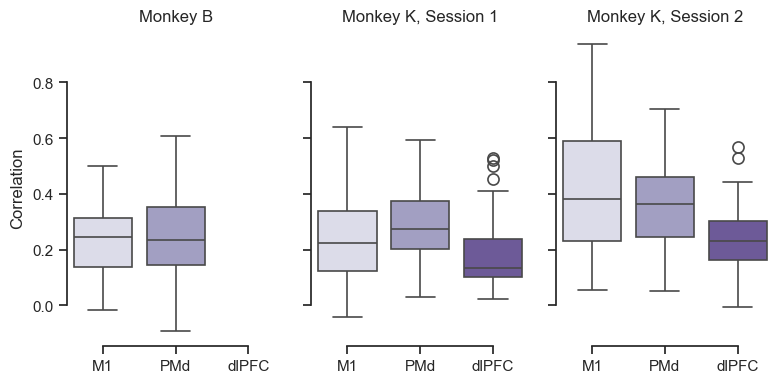

In [12]:
plot_global_corr(start_df, "boxplot_start_corr")

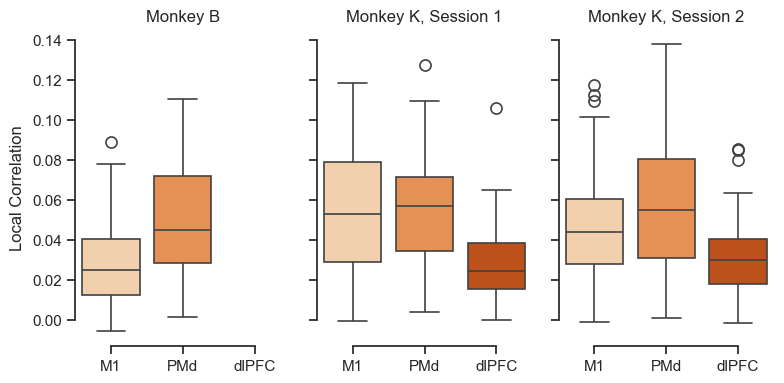

In [13]:
plot_local_corr(start_df, "boxplot_start_local_corr")

### align the end of the trial

In [14]:
end_dict = {
    "area": [],
    "session": [],
    "correlation": [],
    "local_correlation": [],
}

for session in sessions:
    with open(
        os.path.join(session, "responses", "meta", "areas.npy"), "rb"
    ) as f:
        areas = np.load(f)
        end_dict["area"].extend(areas)
        end_dict["session"].extend([session] * len(areas))

    for ch in range(len(areas)):
        trials = [
            list(reversed(trial[:, ch])) for trial in responses_dict[session]
        ]

        pred, gt = loo_pred(trials, choice2idx[session])
        concat_pred = np.concatenate(list(pred.values()))
        concat_gt = np.concatenate(list(gt.values()))
        corr = np.corrcoef(concat_pred, concat_gt)[0, 1]
        end_dict["correlation"].append(corr)

        local_corr = local_looc(trials, choice2idx[session])
        end_dict["local_correlation"].append(local_corr)

/Users/caio/datasets/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/caio/datasets/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/b2/8s0j82vd4439gm59q0ydywkm0000gn/T/ipykernel_20459/3657634990.py:39: RuntimeWarning: Mean of empty slice
  trial_corr[t] = np.nanmean(intervals_corr)


In [15]:
end_df = pd.DataFrame(end_dict)
end_df["area"] = end_df["area"].replace(
    {"M1_L": "M1", "M1_M": "M1", "PMd_M": "PMd", "PMd_L": "PMd"}
)
end_df["alignment"] = "end"
end_df

,area,session,correlation,local_correlation,alignment
0,M1,bex_20230623,0.521483,0.250058,end
1,M1,bex_20230623,0.271704,0.080321,end
2,M1,bex_20230623,0.418612,0.166174,end
3,M1,bex_20230623,0.447643,0.183515,end
4,M1,bex_20230623,0.085292,0.030961,end
...,...,...,...,...,...
579,dlPFC,ken_20230618,0.202873,0.035383,end
580,dlPFC,ken_20230618,0.255785,0.050172,end
581,dlPFC,ken_20230618,0.093130,0.011575,end
582,dlPFC,ken_20230618,0.077428,0.009678,end


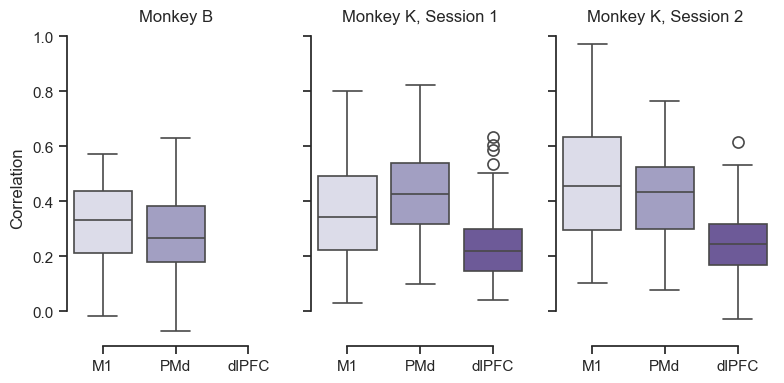

In [16]:
plot_global_corr(end_df, "boxplot_end_corr")

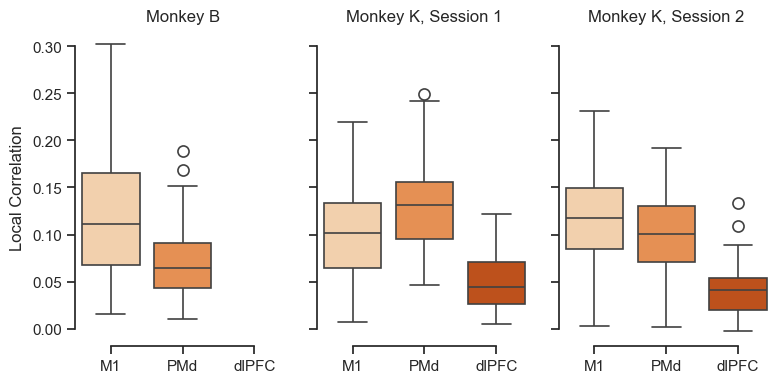

In [17]:
plot_local_corr(end_df, "boxplot_end_local_corr")

### align the tile in the y-axis

##### control

In [90]:
tile_dict = {
    "area": [],
    "session": [],
    "shuffle": [],
    "correlation": [],
    "local_correlation": [],
}
tile_swap = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}

for session in sessions:
    with open(
        os.path.join(session, "responses", "meta", "areas.npy"), "rb"
    ) as f:
        areas = np.load(f)
        tile_dict["area"].extend(areas)
        tile_dict["session"].extend([session] * len(areas))
        tile_dict["shuffle"].extend(["control"] * len(areas))

    trials_com = [com[:, 1].T for com in com_dict[session]]
    for ch in range(len(areas)):
        trials_resp = [trial[:, ch].T for trial in responses_dict[session]]
        pred, gt = spatial_looc(
            trials_resp, trials_com, choice2idx[session], tile_swap
        )
        concat_pred = np.concatenate(list(pred.values()))
        concat_gt = np.concatenate(list(gt.values()))
        corr = np.corrcoef(concat_pred, concat_gt)[0, 1]
        tile_dict["correlation"].append(corr)
        tile_dict["local_correlation"].append(corr)

In [91]:
tile_df = pd.DataFrame(tile_dict)
tile_df["area"] = tile_df["area"].replace(
    {"M1_L": "M1", "M1_M": "M1", "PMd_M": "PMd", "PMd_L": "PMd"}
)
tile_df["alignment"] = "tile"
tile_df

,area,session,shuffle,correlation,local_correlation,alignment
0,M1,bex_20230623,control,0.286770,0.286770,tile
1,M1,bex_20230623,control,0.148037,0.148037,tile
2,M1,bex_20230623,control,0.257917,0.257917,tile
3,M1,bex_20230623,control,0.242669,0.242669,tile
4,M1,bex_20230623,control,0.034114,0.034114,tile
...,...,...,...,...,...,...
579,dlPFC,ken_20230618,control,0.193618,0.193618,tile
580,dlPFC,ken_20230618,control,0.122925,0.122925,tile
581,dlPFC,ken_20230618,control,0.083868,0.083868,tile
582,dlPFC,ken_20230618,control,0.089000,0.089000,tile


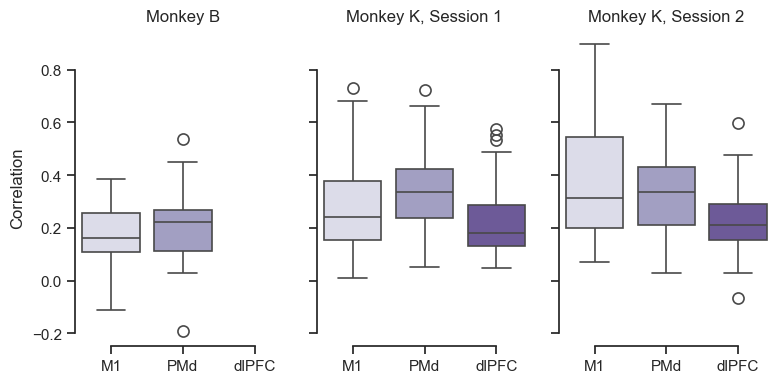

In [92]:
plot_global_corr(tile_df, "boxplot_tile_corr")

##### hard shuffle

to double-check if the tile alignment is actually measuring something, i'll shuffle the trials as follows:
for each trial i'll swap the ground truth activity from tile 1 with tile 3 and from tile 2 with 5.
the fourth tile i leave as it is.

In [156]:
shuffled_tile_dict = {
    "area": [],
    "session": [],
    "shuffle": [],
    "correlation": [],
    "local_correlation": [],
}
tile_swap = {0: 1, 1: 0, 2: 4, 3: 3, 4: 2}  # 0-indexed tiles
chs_to_analyse = {session: {"gt": [], "pred": []} for session in sessions}

for session in sessions:
    with open(
        os.path.join(session, "responses", "meta", "areas.npy"), "rb"
    ) as f:
        areas = np.load(f)
        shuffled_tile_dict["area"].extend(areas)
        shuffled_tile_dict["session"].extend([session] * len(areas))
        shuffled_tile_dict["shuffle"].extend(["hard"] * len(areas))

    trials_com = [com[:, 1].T for com in com_dict[session]]
    for ch in range(len(areas)):
        trials_resp = [trial[:, ch].T for trial in responses_dict[session]]
        pred, gt = spatial_looc(
            trials_resp, trials_com, choice2idx[session], tile_swap
        )
        concat_pred = np.concatenate(list(pred.values()))
        concat_gt = np.concatenate(list(gt.values()))
        corr = np.corrcoef(concat_pred, concat_gt)[0, 1]
        shuffled_tile_dict["correlation"].append(corr)
        shuffled_tile_dict["local_correlation"].append(corr)
        if corr > 0.3:
            chs_to_analyse[session]["pred"].append(concat_pred)
            chs_to_analyse[session]["gt"].append(concat_gt)

In [157]:
shuffled_tile_df = pd.DataFrame(shuffled_tile_dict)
shuffled_tile_df["area"] = shuffled_tile_df["area"].replace(
    {"M1_L": "M1", "M1_M": "M1", "PMd_M": "PMd", "PMd_L": "PMd"}
)
shuffled_tile_df["alignment"] = "tile"
shuffled_tile_df

,area,session,shuffle,correlation,local_correlation,alignment
0,M1,bex_20230623,hard,0.031487,0.031487,tile
1,M1,bex_20230623,hard,0.019125,0.019125,tile
2,M1,bex_20230623,hard,-0.079942,-0.079942,tile
3,M1,bex_20230623,hard,-0.009933,-0.009933,tile
4,M1,bex_20230623,hard,-0.029027,-0.029027,tile
...,...,...,...,...,...,...
579,dlPFC,ken_20230618,hard,0.003469,0.003469,tile
580,dlPFC,ken_20230618,hard,0.094676,0.094676,tile
581,dlPFC,ken_20230618,hard,-0.122110,-0.122110,tile
582,dlPFC,ken_20230618,hard,0.032961,0.032961,tile


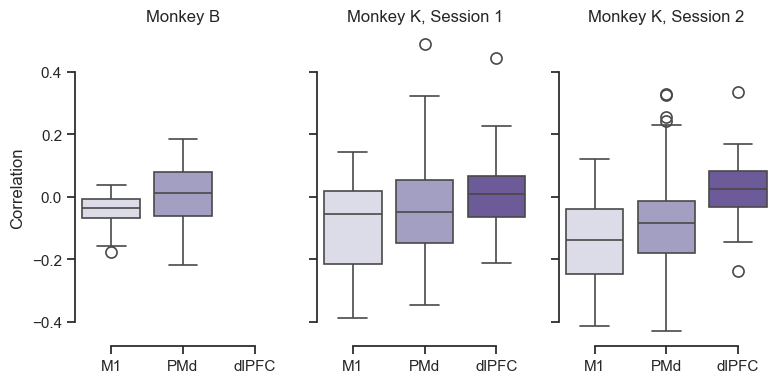

In [158]:
plot_global_corr(shuffled_tile_df, "boxplot_shuffled_tile_corr")

In [ ]:
com_conditioned = {
    session: [
        com_dict[session][idx] for idx in np.concatenate([cond["L"], cond["R"]])
    ]
    for session, cond in choice2idx.items()
}

com_stacked = {
    session: np.concatenate(com_conditioned[session], axis=0)[:, 1]
    for session in com_dict
}

com_digitized = {
    session: np.digitize(com_stacked[session], bins=np.linspace(0, 1, 6)) - 1
    for session in com_stacked
}

In [ ]:
change_points = {
    session: np.where(np.diff(com_digitized[session]) != 0)[0]
    for session in com_digitized
}

segment_starts = {
    session: np.r_[0, change_points[session] + 1] for session in change_points
}

segment_ends = {
    session: np.r_[change_points[session], len(com_digitized[session]) - 1]
    for session in change_points
}

In [ ]:
colors = [plt.get_cmap("YlOrBr")(i) for i in np.linspace(0.2, 0.7, 5)]

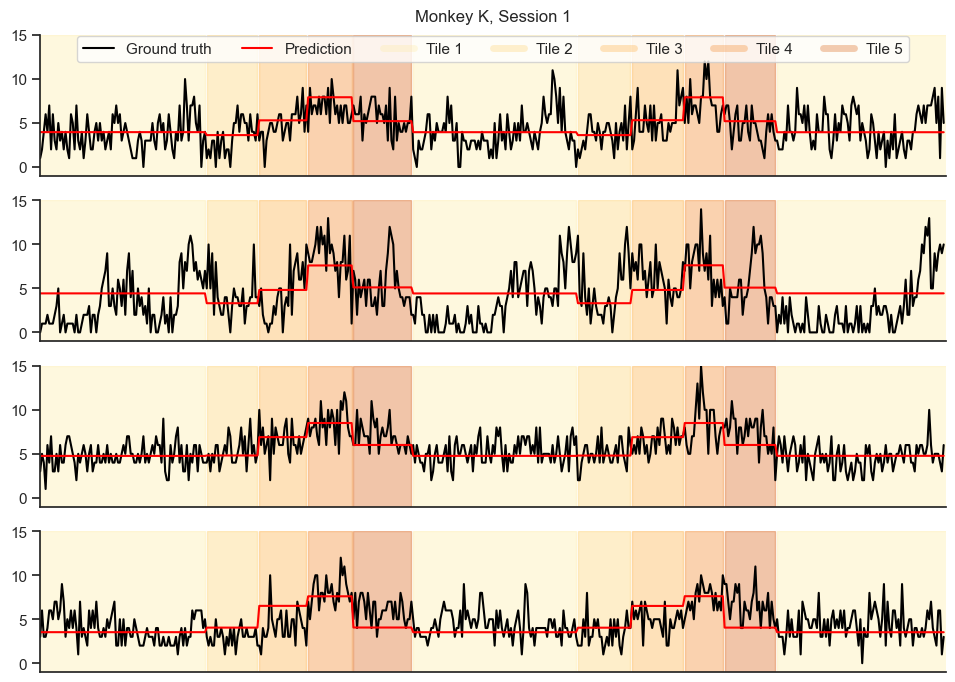

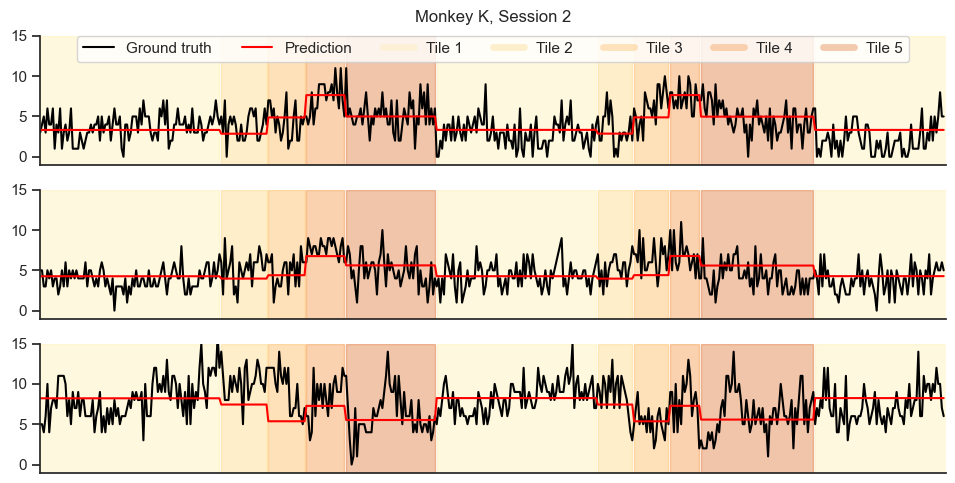

In [275]:
for session in chs_to_analyse:
    gts = list(reversed(chs_to_analyse[session]["gt"]))
    preds = reversed(chs_to_analyse[session]["pred"])
    if not gts:
        continue

    # Set figure size
    height = 7 if "14" in session else 5
    fig, axs = plt.subplots(
        len(gts), 1, figsize=(10, height), sharex=True, sharey=True
    )

    # Ensure axs is iterable
    axs = np.atleast_1d(axs)

    time = 500
    for i, (gt, pred) in enumerate(zip(gts, preds)):
        t = np.arange(len(gt))

        # Add colored background spans
        for start, end in zip(segment_starts[session], segment_ends[session]):
            if start > time:
                break
            tile = com_digitized[session][start]
            axs[i].axvspan(t[start], t[end], color=colors[tile], alpha=0.35)

        axs[i].plot(t[:time], gt[:time], color="black", label="Ground truth")
        axs[i].plot(t[:time], pred[:time], color="red", label="Prediction")

    # Create legend handles
    handles, _ = axs[-1].get_legend_handles_labels()
    tile_handles = [
        plt.Line2D(
            [0],
            [0],
            color=colors[tile],
            lw=5,
            alpha=0.3,
            label=f"Tile {tile+1}",
        )
        for tile in range(5)
    ]
    handles.extend(tile_handles)

    title = "Monkey K, Session 1" if "14" in session else "Monkey K, Session 2"
    axs[0].set_title(title, pad=10)
    axs[0].legend(
        handles=handles, loc="center", bbox_to_anchor=(0.5, 0.90), ncol=7
    )

    sns.despine(right=True, top=True)
    plt.xlim(0, time)
    plt.ylim(-1, 15)
    plt.xticks([])
    plt.yticks([0, 5, 10, 15])
    plt.tight_layout()
    plt.savefig(
        f"{PLOTS_FOLDER}/traces_neural_hard_shuffled_{session}.svg",
        format="svg",
        bbox_inches="tight",
    )
    plt.show()
    plt.close()

##### walk shuffle

here i'll swap only the middle tiles because it's where the monkeys are walking. i don't expect to see a big difference.

In [26]:
shuffled_walk_tile_dict = {
    "area": [],
    "session": [],
    "shuffle": [],
    "correlation": [],
    "local_correlation": [],
}
tile_swap = {0: 0, 1: 2, 2: 3, 3: 1, 4: 4}  # 0-indexed tiles

for session in sessions:
    with open(
        os.path.join(session, "responses", "meta", "areas.npy"), "rb"
    ) as f:
        areas = np.load(f)
        shuffled_walk_tile_dict["area"].extend(areas)
        shuffled_walk_tile_dict["session"].extend([session] * len(areas))
        shuffled_walk_tile_dict["shuffle"].extend(["walk"] * len(areas))

    trials_com = [com[:, 1].T for com in com_dict[session]]
    for ch in range(len(areas)):
        trials_resp = [trial[:, ch].T for trial in responses_dict[session]]
        pred, gt = spatial_looc(
            trials_resp, trials_com, choice2idx[session], tile_swap
        )
        concat_pred = np.concatenate(list(pred.values()))
        concat_gt = np.concatenate(list(gt.values()))
        corr = np.corrcoef(concat_pred, concat_gt)[0, 1]
        shuffled_walk_tile_dict["correlation"].append(corr)
        shuffled_walk_tile_dict["local_correlation"].append(corr)

In [27]:
shuffled_walk_tile_df = pd.DataFrame(shuffled_walk_tile_dict)
shuffled_walk_tile_df["area"] = shuffled_walk_tile_df["area"].replace(
    {"M1_L": "M1", "M1_M": "M1", "PMd_M": "PMd", "PMd_L": "PMd"}
)
shuffled_walk_tile_df["alignment"] = "tile"
shuffled_walk_tile_df

,area,session,shuffle,correlation,local_correlation,alignment
0,M1,bex_20230623,walk,0.280209,0.280209,tile
1,M1,bex_20230623,walk,0.149013,0.149013,tile
2,M1,bex_20230623,walk,0.255778,0.255778,tile
3,M1,bex_20230623,walk,0.241059,0.241059,tile
4,M1,bex_20230623,walk,0.036070,0.036070,tile
...,...,...,...,...,...,...
579,dlPFC,ken_20230618,walk,0.177822,0.177822,tile
580,dlPFC,ken_20230618,walk,0.064359,0.064359,tile
581,dlPFC,ken_20230618,walk,0.080821,0.080821,tile
582,dlPFC,ken_20230618,walk,0.054452,0.054452,tile


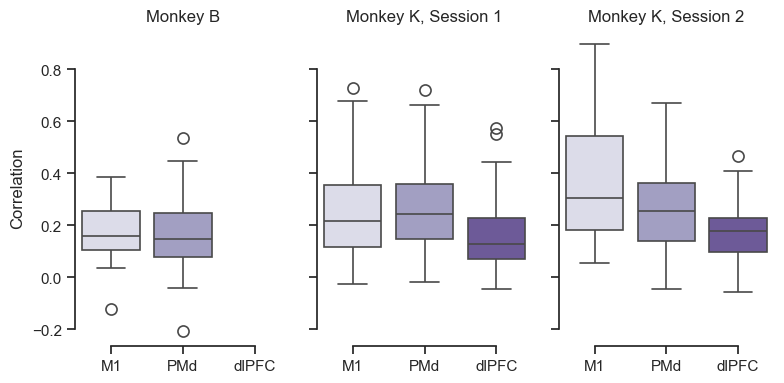

In [28]:
plot_global_corr(shuffled_walk_tile_df, "boxplot_shuffled_walk_tile_corr")

##### comparing the shuffles

In [29]:
shuffles_df = pd.concat([shuffled_tile_df, shuffled_walk_tile_df, tile_df])
shuffles_df

,area,session,shuffle,correlation,local_correlation,alignment
0,M1,bex_20230623,hard,-0.009616,-0.009616,tile
1,M1,bex_20230623,hard,-0.015322,-0.015322,tile
2,M1,bex_20230623,hard,0.030867,0.030867,tile
3,M1,bex_20230623,hard,0.004757,0.004757,tile
4,M1,bex_20230623,hard,-0.024217,-0.024217,tile
...,...,...,...,...,...,...
579,dlPFC,ken_20230618,control,0.193618,0.193618,tile
580,dlPFC,ken_20230618,control,0.122925,0.122925,tile
581,dlPFC,ken_20230618,control,0.083868,0.083868,tile
582,dlPFC,ken_20230618,control,0.089000,0.089000,tile


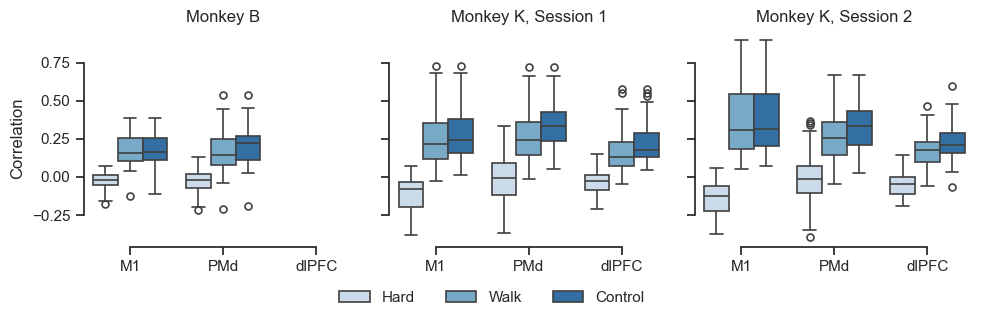

In [286]:
g = sns.catplot(
    data=shuffles_df,
    x="area",
    y="correlation",
    hue="shuffle",
    col="session",
    kind="box",
    palette="Blues",
    sharex=True,
    sharey=True,
    linewidth=1.2,
    flierprops={"marker": "o", "markersize": 5, "markeredgewidth": 1.2},
)

g.figure.set_size_inches(10, 3)
sns.despine(trim=True)
axs = list(g.axes.flat)
axs[0].set_title("Monkey B")
axs[1].set_title("Monkey K, Session 1")
axs[2].set_title("Monkey K, Session 2")
g.set_ylabels("Correlation", labelpad=5)
g.set_xlabels("")
g.legend.set_title("")

for text in g.legend.get_texts():
    text.set_text(text.get_text().capitalize())

sns.move_legend(g, loc="center", bbox_to_anchor=(0.5, -0.02), ncol=4)

plt.tight_layout()
plt.savefig(
    f"{PLOTS_FOLDER}/boxplot_shuffle_comparison.svg",
    format="svg",
    bbox_inches="tight",
)
plt.show()

### comparing with my model

In [31]:
CONFIGS_DIR = "outputs"
RESULTS_DIR = os.path.join("results", "gbyk")
runs = ["20250317054142"]
model_dict = {
    "session": [],
    "correlation": [],
    "local_correlation": [],
    "area": [],
    "alignment": [],
}

for run in runs:
    with open(
        os.path.join(RESULTS_DIR, run, "trial_correlation.pkl"), "rb"
    ) as f:
        trial_corr = pickle.load(f)

    with open(
        os.path.join(RESULTS_DIR, run, "local_correlation.pkl"), "rb"
    ) as f:
        local_corr = pickle.load(f)

    for monkey in trial_corr:
        with open(
            os.path.join(monkey, "responses", "meta", "areas.npy"), "rb"
        ) as f:
            areas = np.load(f)

        model_dict["session"].extend([monkey] * len(areas))
        model_dict["correlation"].extend(trial_corr[monkey])
        model_dict["local_correlation"].extend(local_corr[monkey])
        model_dict["area"].extend(areas)
        model_dict["alignment"].extend(["model"] * len(areas))

In [32]:
model_df = pd.DataFrame.from_dict(model_dict)
model_df["area"] = model_df["area"].replace(
    {"M1_L": "M1", "M1_M": "M1", "PMd_M": "PMd", "PMd_L": "PMd"}
)
# model_df = model_df[model_df["area"] != "dlPFC"]
model_df

,session,correlation,local_correlation,area,alignment
0,bex_20230623,0.567539,0.472139,M1,model
1,bex_20230623,0.287127,0.179344,M1,model
2,bex_20230623,0.544679,0.356375,M1,model
3,bex_20230623,0.500678,0.258824,M1,model
4,bex_20230623,0.128775,0.178934,M1,model
...,...,...,...,...,...
579,ken_20230618,0.227966,0.202784,dlPFC,model
580,ken_20230618,0.290912,0.130408,dlPFC,model
581,ken_20230618,0.135774,0.010503,dlPFC,model
582,ken_20230618,0.151316,-0.045192,dlPFC,model


In [33]:
merged_df = pd.concat([tile_df, start_df, end_df, model_df], ignore_index=True)
merged_df

,area,session,shuffle,correlation,local_correlation,alignment
0,M1,bex_20230623,control,0.286770,0.286770,tile
1,M1,bex_20230623,control,0.148037,0.148037,tile
2,M1,bex_20230623,control,0.257917,0.257917,tile
3,M1,bex_20230623,control,0.242669,0.242669,tile
4,M1,bex_20230623,control,0.034114,0.034114,tile
...,...,...,...,...,...,...
2331,dlPFC,ken_20230618,NaN,0.227966,0.202784,model
2332,dlPFC,ken_20230618,NaN,0.290912,0.130408,model
2333,dlPFC,ken_20230618,NaN,0.135774,0.010503,model
2334,dlPFC,ken_20230618,NaN,0.151316,-0.045192,model


In [289]:
xkcd_palette = ["lightish purple", "mango", "turquoise", "cherry red"]
sns.set_palette(sns.xkcd_palette(xkcd_palette))

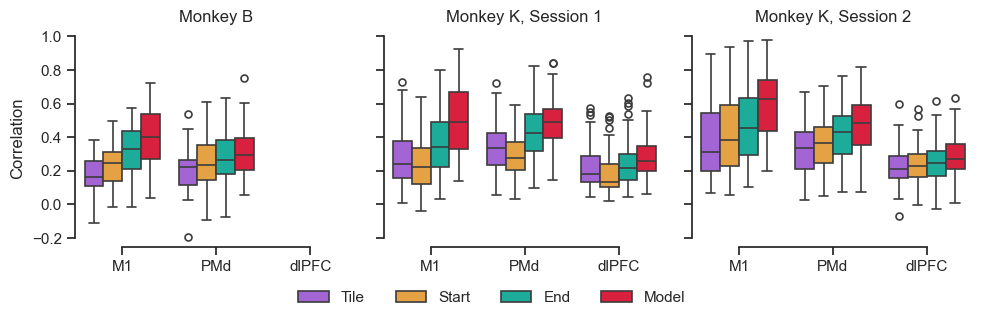

In [291]:
g = sns.catplot(
    data=merged_df,
    x="area",
    y="correlation",
    hue="alignment",
    col="session",
    kind="box",
    sharex=True,
    sharey=True,
    linewidth=1.2,
    flierprops={"marker": "o", "markersize": 5, "markeredgewidth": 1.2},
)

g.figure.set_size_inches(10, 3)
sns.despine(trim=True)
axs = list(g.axes.flat)
axs[0].set_title("Monkey B")
axs[1].set_title("Monkey K, Session 1")
axs[2].set_title("Monkey K, Session 2")
g.set_ylabels("Correlation", labelpad=5)
g.set_xlabels("")
g.legend.set_title("")

for text in g.legend.get_texts():
    text.set_text(text.get_text().capitalize())

sns.move_legend(g, loc="center", bbox_to_anchor=(0.5, -0.02), ncol=4)

plt.tight_layout()
plt.savefig(
    f"{PLOTS_FOLDER}/boxplot_model_comparison.svg",
    format="svg",
    bbox_inches="tight",
)
plt.show()